In [ ]:
import os
import pickle
import numpy as np
import multiprocessing

import sys
sys.path.insert(1, '../../../cell2cell/')
import cell2cell as c2c
from cell2cell.tensor.tensor import BaseTensor
from cell2cell.tensor.factorization import _compute_norm_error

sys.path.insert(1, '../../../scripts/')
from simulation.simulate import Simulate, CCI_MD


# specify path to save figures
fig_path = ''#'/data2/hratch/cci_dt/figures/'
data_path = ''#'/data2/hratch/cci_dt/noise_v_error/'
version = 1

# Generate Simulated Tensor

In [41]:
# init
sim = Simulate() 

# simulate a scale_free randomly connected ligand-receptor network (potential interactions)
sim.LR_network(network_type = 'scale-free', **{'nodes': 100, 'degrees': 3, 'alpha': 2}) #scale-free

# LR metadata
sim.LR.generate_metadata(n_LR_cats = {3: 0}, cat_skew = 0)

# generate cell metadata, accounting for directionality (senders vs receivers) and 
# allowing for autocrine interactions 
cci = CCI_MD()
cci.cci_network(n_cells = 50, directional = True, autocrine = True)

# generate 1 metadata categories, with 3 subcategories and 0 skew, the overall skew of categories is 0
# do not remove homotypic interactions (will be included)
cci.generate_metadata(n_cell_cats = {3: 0}, cat_skew = 0, remove_homotypic = 0)
# add cell metadata to simulation object
sim.cci = cci

# generate n_patter metadata groups of CC-LR pairs that change across n_conditions
# these changes can either be linear, oscillating, or a pulse; allow homotypic interactions to form patterns
# maximize the possible change in communication score
sim.generate_tensor_md(n_patterns = 4, n_conditions = 12, patterns = ['pulse', 'linear', 'oscillate', 'power'], 
                      consider_homotypic = True, score_change = 'max')

#generate a tensor with continuous LR scores and baseline noise; keep single-cells 
sim.generate_tensor(noise = 0.01, binary = False, bulk = True, noise_max = None)

# format the tensor to be input to tensor-cell2cell
sim.reshape()

/home/hratch/Projects/cci_dt/notebooks/simulation/other_analyses/tmpl7smqwyy_bipartite_sf.csv
Generate undirected, bipartite, scale-free graph
Check network properties
All properties are as expected


../../../scripts/simulation/graphs.py:164: UserWarning: 65 nodes are disconnected, removing from network
  warnings.warn(mssg)
 17%|█▋        | 2/12 [00:00<00:00, 19.83it/s]

Generate reshaped tensor


100%|██████████| 12/12 [00:00<00:00, 20.20it/s]


In [42]:
tensor = BaseTensor()
t1 = sim.sim_tensor.tensor_cci
tensor.tensor = t1
tensor.order_names = [['Context-{}'.format(c+1) for c in range(t1.shape[0])],
                      ['LR-{}'.format(c+1) for c in range(t1.shape[1])],
                      ['Sender-{}'.format(c+1) for c in range(t1.shape[2])],
                      ['Receiver-{}'.format(c+1) for c in range(t1.shape[3])]
                     ]

  0%|          | 0/5 [00:00<?, ?it/s]

(<Figure size 288x162 with 1 Axes>,
 [(1, 0.5447823051969775),
  (2, 0.31998107486445726),
  (3, 0.31991611380083645),
  (4, 0.020250255154272007),
  (5, 0.02022686010205743)])

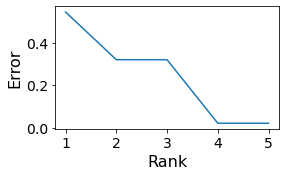

In [43]:
tensor.elbow_rank_selection(5)

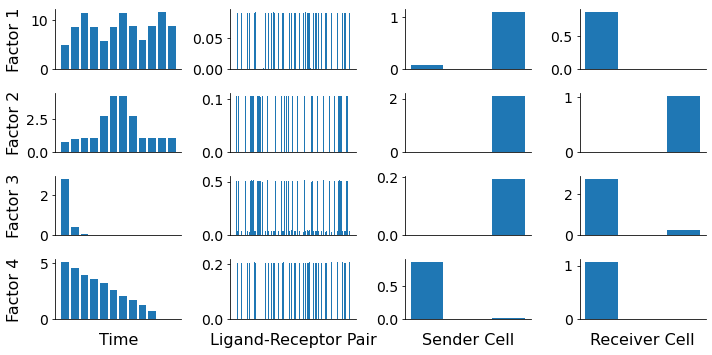

In [45]:
tensor.compute_tensor_factorization(rank=4)
fig, axes = c2c.plotting.tensor_factors_plot(interaction_tensor=tensor,
                                             order_labels=['Time', 'Ligand-Receptor Pair', 'Sender Cell', 'Receiver Cell'],
                                             #metadata = tensor.order_names,
                                             #sample_col='Order',
                                             #group_col='Element',
                                             #meta_cmaps=['viridis', 'tab20', 'Pastel1', 'Pastel1'],
                                             fontsize=14# filename=fig_path + 'TF_SIM_v' + str(version) + '.svg'
                                            )
sim.pickle(data_path + 'sim_obj_v' + str(version) + '.pickle')

# Error vs Noise

In [32]:
n_iter = 100 # of iterations per noise value
n_cores = 20 # number of cores for parallelization

with open(data_path + 'sim_obj_v' + str(version) + '.pickle', 'rb') as f:
    sim = pickle.load(f)

fn = data_path + 'error_vs_noise_' + str(version) + '.tab' # save results here
if not os.path.isfile(fn):
    with open(fn, 'w') as f:
        f.write('Noise' + '\t' + 'Error' + '\n')
else:
    raise ValueError('Unexpected results file already exists')

In [33]:
def get_error(noise):
    try:
        sim.generate_tensor(noise = noise, binary = False, bulk = True, noise_max = None)
        tensor_ = BaseTensor()
        tensor_.tensor = sim.sim_tensor.tensor_cci

        r, err = _compute_norm_error(rank = sim.sim_tensor.rank, interaction_tensor = tensor_)
        with open(fn, 'a') as f:
            f.write(str(noise) + '\t' + str(err) + '\n')
    except:
        with open(fn, 'a') as f:
            f.write('fail' + '\t' + 'fail' + '\n')

../../../scripts/simulation/simulate.py:650: UserWarning: Only continuous scoring is currently implemented
  warnings.warn('Only continuous scoring is currently implemented')
../../../scripts/simulation/simulate.py:704: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df.values[coords] = utils.get_truncated_normal(n = len(coords[0]),


In [ ]:
for noise in list(np.arange(0.01,0.1, 0.01)) + list(np.arange(0.1,1.01,0.1)):
    print('------------------------------------------')
    print('Noise: {:.2f}'.format(noise))
    
    pool = multiprocessing.Pool(processes = n_cores)
    try:
        pool.map(get_error, [noise]*n_iter)
        pool.close()
        pool.join()
    except:
        pool.close()
        pool.join()
        raise ValueError('Parallelization failed at noise: {:.2f}'.format(noise))